<a href="https://colab.research.google.com/github/Shailajgautam/Sentiment_Analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Required Dependencies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 5.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

# **Loading and cleaning the data**

In [5]:
# Load datasets with encoding
train_data = pd.read_csv('/content/drive/MyDrive/sentiment_data/training.1600000.processed.noemoticon.csv', encoding='latin1')
test_data = pd.read_csv('/content/drive/MyDrive/sentiment_data/testdata.manual.2009.06.14.csv', encoding='latin1')

# Rename columns appropriately
train_data.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
test_data.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Print the first few rows of the datasets
print(train_data.head())
print(test_data.head())


   target         ids                          date      flag           user  \
0       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton   
1       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus   
2       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF   
3       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli   
4       0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf   

                                                text  
0  is upset that he can't update his Facebook by ...  
1  @Kenichan I dived many times for the ball. Man...  
2    my whole body feels itchy and like its on fire   
3  @nationwideclass no, it's not behaving at all....  
4                      @Kwesidei not the whole crew   
   target  ids                          date     flag          user  \
0       4    4  Mon May 11 03:18:03 UTC 2009  kindle2        vcu451   
1       4    5  Mon May 11 03:18:54 UTC 2009  k

**Verifying the values for negative and positive in dataset target column**

In [6]:
# Get unique values for the target column in the training data
train_targets = train_data['target'].unique()
print("Unique values in the target column of the training data:", train_targets)

# Get unique values for the target column in the test data
test_targets = test_data['target'].unique()
print("Unique values in the target column of the test data:", test_targets)


Unique values in the target column of the training data: [0 4]
Unique values in the target column of the test data: [4 0 2]


**Converting 4 to 1 (postive) and removing 2 which is neutral**

In [7]:
# Map target values
train_data['target'] = train_data['target'].map({0: 0, 4: 1})
test_data = test_data[test_data['target'] != 2]  # Remove neutral samples
test_data['target'] = test_data['target'].map({0: 0, 4: 1})

# Verify the mapping
print("Unique values in the target column of the training data:", train_data['target'].unique())
print("Unique values in the target column of the test data:", test_data['target'].unique())

Unique values in the target column of the training data: [0 1]
Unique values in the target column of the test data: [1 0]


In [8]:
# Print the first few rows of the datasets
print(train_data.head())
print(test_data.head())

   target         ids                          date      flag           user  \
0       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton   
1       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus   
2       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF   
3       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli   
4       0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf   

                                                text  
0  is upset that he can't update his Facebook by ...  
1  @Kenichan I dived many times for the ball. Man...  
2    my whole body feels itchy and like its on fire   
3  @nationwideclass no, it's not behaving at all....  
4                      @Kwesidei not the whole crew   
   target  ids                          date     flag          user  \
0       1    4  Mon May 11 03:18:03 UTC 2009  kindle2        vcu451   
1       1    5  Mon May 11 03:18:54 UTC 2009  k

**Droping all uneccesary columns**

In [9]:
# Drop unnecessary columns
train_data = train_data[['text', 'target']]
test_data = test_data[['text', 'target']]

# Verify the resulting dataframes
print(train_data.head())
print(test_data.head())

                                                text  target
0  is upset that he can't update his Facebook by ...       0
1  @Kenichan I dived many times for the ball. Man...       0
2    my whole body feels itchy and like its on fire        0
3  @nationwideclass no, it's not behaving at all....       0
4                      @Kwesidei not the whole crew        0
                                                text  target
0  Reading my kindle2...  Love it... Lee childs i...       1
1  Ok, first assesment of the #kindle2 ...it fuck...       1
2  @kenburbary You'll love your Kindle2. I've had...       1
3  @mikefish  Fair enough. But i have the Kindle2...       1
4  @richardebaker no. it is too big. I'm quite ha...       1


**Visualizing distribution of target variable**

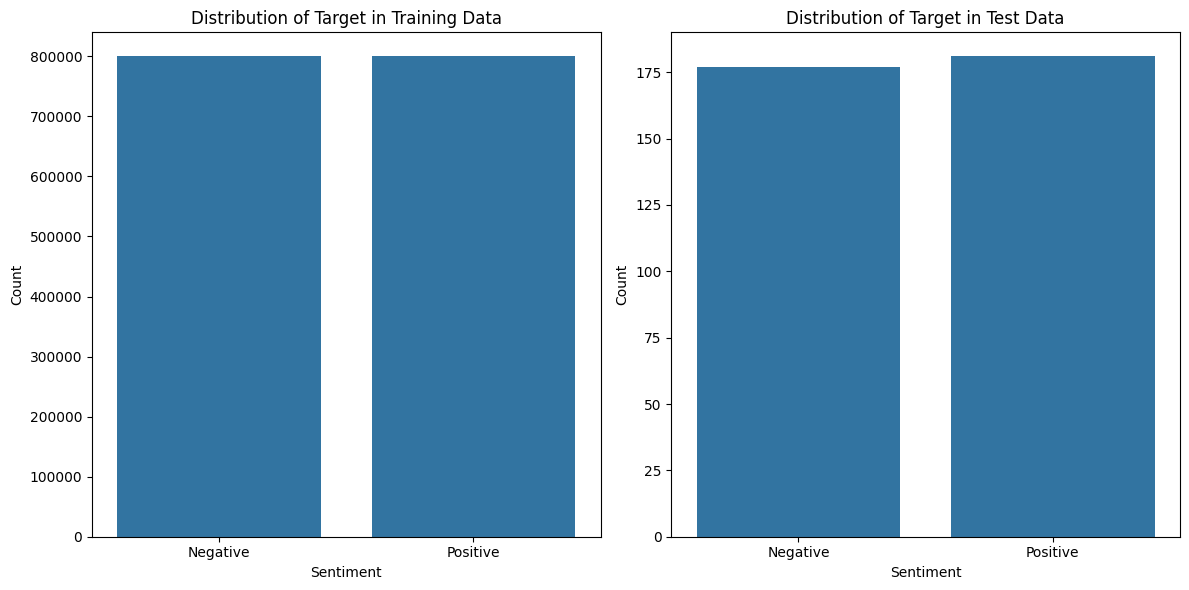

In [10]:
# Plot the distribution of the target variable in the training data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])  # Set x-axis labels

# Plot the distribution of the target variable in the test data
plt.subplot(1, 2, 2)
sns.countplot(x='target', data=test_data)
plt.title('Distribution of Target in Test Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])  # Set x-axis labels

# Display the plots
plt.tight_layout()
plt.show()


**Cleaning the text to standarize the input for the model**

In [11]:

# Download necessary NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stemmer, lemmatizer, and stopwords
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Convert emojis to text
    text = emoji.demojize(text)

    # Remove stopwords and apply stemming and lemmatization
    words = text.split()
    cleaned_words = []
    for word in words:
        if word not in stop_words:
            stemmed_word = stemmer.stem(word)
            lemmatized_word = lemmatizer.lemmatize(stemmed_word)
            cleaned_words.append(lemmatized_word)

    # Join cleaned words back into a single string and normalize whitespace
    cleaned_text = ' '.join(cleaned_words)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

# Clean the text data
train_data['text'] = train_data['text'].apply(clean_text)
test_data['text'] = test_data['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Calculating sequence lengths of tweets to see the optimal maxlen for sequence length**

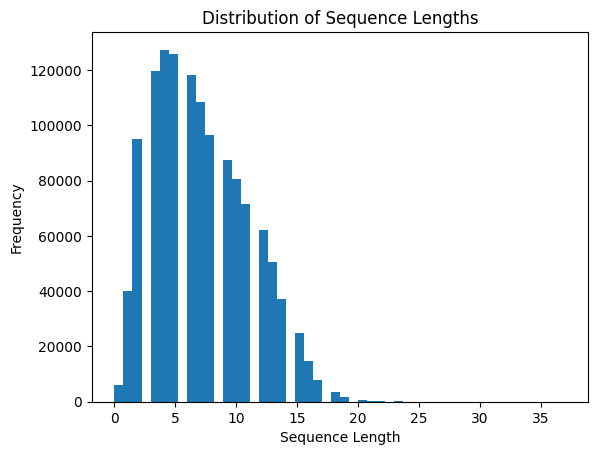

Mean sequence length: 7.138520740699664
Median sequence length: 7.0
Max sequence length: 37
90th percentile: 13.0
95th percentile: 14.0


In [12]:
# Create a validation set from the training data
X_train, X_val, y_train, y_val = train_test_split(train_data['text'], train_data['target'], test_size=0.2, random_state=42)

# Combine text data to build a common vocabulary
combined_texts = pd.concat([train_data['text'], test_data['text']])

# Tokenizer initialization without limiting num_words
tokenizer = Tokenizer(oov_token='<OOV>')

# Fit the tokenizer on the combined text data
tokenizer.fit_on_texts(combined_texts)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# Calculate the length of each sequence
sequence_lengths = [len(seq) for seq in train_sequences + test_sequences]

# Plot the distribution of sequence lengths
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Print some statistics about sequence lengths
print(f"Mean sequence length: {np.mean(sequence_lengths)}")
print(f"Median sequence length: {np.median(sequence_lengths)}")
print(f"Max sequence length: {np.max(sequence_lengths)}")

# Calculate the 90th and 95th percentiles
percentile_90 = np.percentile(sequence_lengths, 90)
percentile_95 = np.percentile(sequence_lengths, 95)
print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")

**Building Vacabulary**

In [13]:
# Pad sequences to ensure uniform length
max_length = 14  # This can be adjusted based on the percentiles calculated
X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Extract target values
Y_train_labels = np.array(y_train)
Y_val_labels = np.array(y_val)
Y_test_labels = np.array(test_data['target'])

# Ensure unique words in the tokenizer
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index for padding


**Wordcloud for negative and positive tweet**

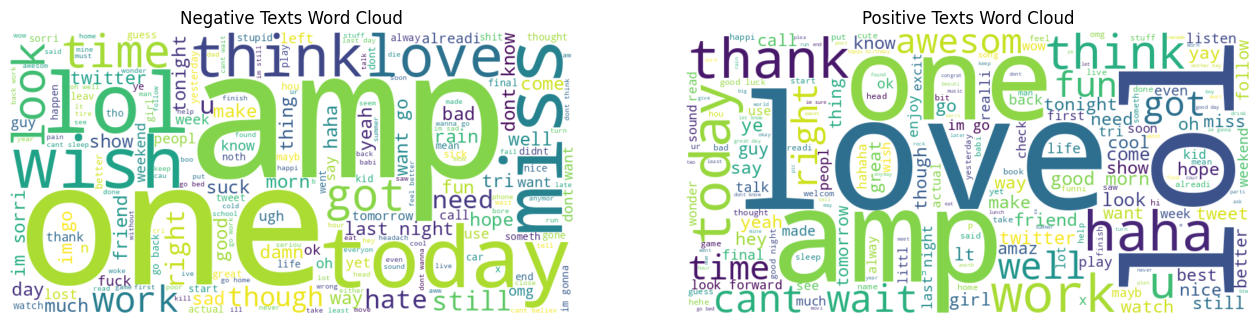

In [14]:

# Separate positive and negative texts for word clouds
positive_texts = " ".join(train_data[train_data['target'] == 1]['text'])
negative_texts = " ".join(train_data[train_data['target'] == 0]['text'])

# Generate word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)

# Plot the word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Texts Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Texts Word Cloud')
plt.axis('off')

plt.show()

# **Building the Model**

In [15]:
# Define model parameters
embedding_dim = 100
gru_units = 32
learning_rate = 0.001
epochs = 20
batch_size = 256

# Define k-fold cross-validation parameters
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize performance metrics
fold_accuracies, fold_precisions, fold_recalls, fold_f1s = [], [], [], []

# Prepare data for k-fold cross-validation
X_data = np.array(train_data['text'])
y_data = np.array(train_data['target'])


In [16]:

for fold, (train_index, val_index) in enumerate(skf.split(X_data, y_data)):
    print(f"Training fold {fold + 1} / {n_splits}")

    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_data[train_index], X_data[val_index]
    y_train_fold, y_val_fold = y_data[train_index], y_data[val_index]

    # Tokenize and pad sequences
    train_sequences_fold = tokenizer.texts_to_sequences(X_train_fold)
    val_sequences_fold = tokenizer.texts_to_sequences(X_val_fold)

    X_train_padded_fold = pad_sequences(train_sequences_fold, maxlen=max_length, padding='post', truncating='post')
    X_val_padded_fold = pad_sequences(val_sequences_fold, maxlen=max_length, padding='post', truncating='post')

    Y_train_labels_fold = np.array(y_train_fold)
    Y_val_labels_fold = np.array(y_val_fold)

    # Build the model (reset for each fold)
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Bidirectional(GRU(units=gru_units, return_sequences=False)),
        Dropout(0.5),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping and learning rate reduction callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

    # Fit the model
    history = model.fit(
        X_train_padded_fold,
        Y_train_labels_fold,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_padded_fold, Y_val_labels_fold),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluate the model on the validation set for the current fold
    val_loss, val_accuracy = model.evaluate(X_val_padded_fold, Y_val_labels_fold)
    print(f"Fold {fold + 1} - Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    val_predictions = (model.predict(X_val_padded_fold) > 0.5).astype(int)
    fold_precision = precision_score(Y_val_labels_fold, val_predictions)
    fold_recall = recall_score(Y_val_labels_fold, val_predictions)
    fold_f1 = f1_score(Y_val_labels_fold, val_predictions)

    # Append metrics for current fold
    fold_accuracies.append(val_accuracy)
    fold_precisions.append(fold_precision)
    fold_recalls.append(fold_recall)
    fold_f1s.append(fold_f1)


Training fold 1 / 5
Epoch 1/20
5000/5000 [==============================] - 126s 23ms/step - loss: 0.4886 - accuracy: 0.7682 - val_loss: 0.4517 - val_accuracy: 0.7871 - lr: 0.0010
Epoch 2/20
5000/5000 [==============================] - 86s 17ms/step - loss: 0.4252 - accuracy: 0.8075 - val_loss: 0.4488 - val_accuracy: 0.7894 - lr: 0.0010
Epoch 3/20
5000/5000 [==============================] - 82s 16ms/step - loss: 0.3775 - accuracy: 0.8348 - val_loss: 0.4759 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 4/20
5000/5000 [==============================] - 83s 17ms/step - loss: 0.3353 - accuracy: 0.8545 - val_loss: 0.4920 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 5/20
10000/10000 [==============================] - 38s 4ms/step - loss: 0.4488 - accuracy: 0.7894
Fold 1 - Validation Loss: 0.44882842898368835, Validation Accuracy: 0.7894218564033508
10000/10000 [==============================] - 31s 3ms/step
Training fold 2 / 5
Epoch 1/20
5000/5000 [==============================] - 108s 21ms/step 

In [17]:
# Calculate and print average metrics across all folds
print(f"Average Validation Accuracy: {np.mean(fold_accuracies)}")
print(f"Average Validation Precision: {np.mean(fold_precisions)}")
print(f"Average Validation Recall: {np.mean(fold_recalls)}")
print(f"Average Validation F1 Score: {np.mean(fold_f1s)}")

Average Validation Accuracy: 0.7881454825401306
Average Validation Precision: 0.7956928136030855
Average Validation Recall: 0.7763774999999999
Average Validation F1 Score: 0.7854824345985808


# **Evaluating the model**

In [18]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_padded, Y_test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

test_predictions = (model.predict(X_test_padded) > 0.5).astype(int)

# Calculate precision, recall, and F1 score for test data
test_precision = precision_score(Y_test_labels, test_predictions)
test_recall = recall_score(Y_test_labels, test_predictions)
test_f1 = f1_score(Y_test_labels, test_predictions)

print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")


12/12 [==============================] - 0s 7ms/step - loss: 0.4086 - accuracy: 0.7989
Test Loss: 0.40859371423721313
Test Accuracy: 0.7988826632499695
12/12 [==============================] - 0s 3ms/step
Test Precision: 0.7945945945945946
Test Recall: 0.8121546961325967
Test F1 Score: 0.8032786885245901


**Classification Report**

In [19]:
# Generate classification report
class_report = classification_report(Y_test_labels, test_predictions, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.79      0.79       177
    Positive       0.79      0.81      0.80       181

    accuracy                           0.80       358
   macro avg       0.80      0.80      0.80       358
weighted avg       0.80      0.80      0.80       358



**Confusion Matrix**

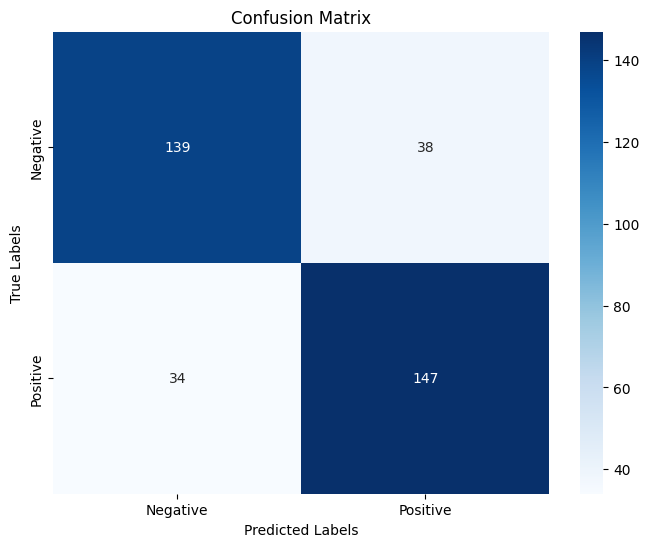

In [20]:
# Generate confusion matrix
conf_matrix = confusion_matrix(Y_test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Graph of training and validation accuracy and loss values**

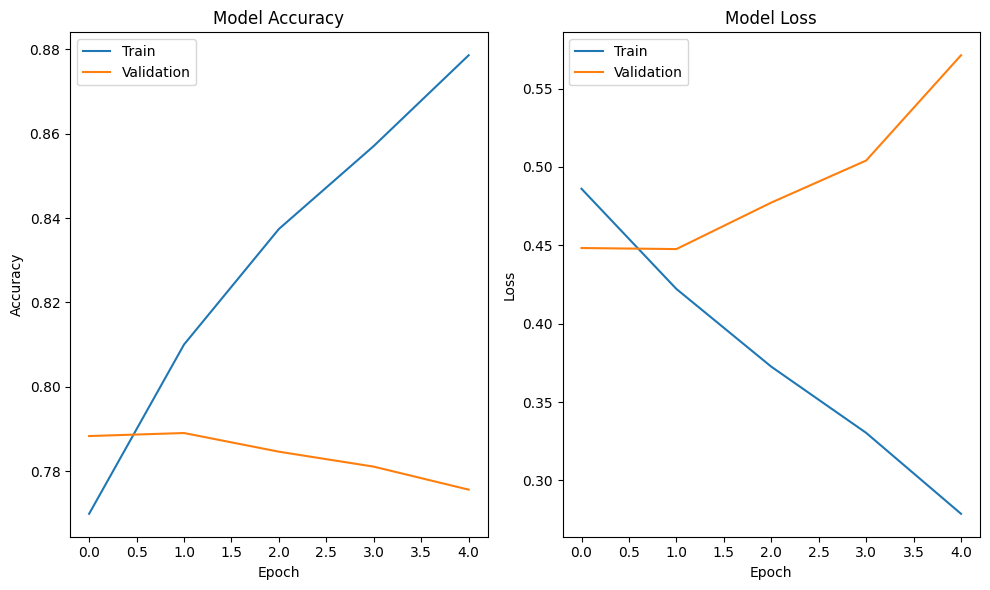

In [21]:

# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


**Classifying tweets**

In [22]:
def classify_tweet(tweet):
    tweet = clean_text(tweet)  # Ensure you have the clean_text function defined
    sequence = tokenizer.texts_to_sequences([tweet])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(padded)[0][0]  # Get the prediction score
    sentiment = 'Positive' if prediction >= 0.5 else 'Negative'
    return sentiment, prediction


In [23]:
# Test the function with a new tweet
new_tweet = "I love this product! It's amazing."
sentiment, score = classify_tweet(new_tweet)
print(f'Tweet: "{new_tweet}" | Sentiment: {sentiment} | Score: {score:.4f}')


1/1 [==============================] - 0s 43ms/step
Tweet: "I love this product! It's amazing." | Sentiment: Positive | Score: 0.9886


In [24]:
# Test the function with another tweet
new_tweet = "I can't working 9 to 5 ahhhh!!!!"
sentiment, score = classify_tweet(new_tweet)
print(f'Tweet: "{new_tweet}" | Sentiment: {sentiment} | Score: {score:.4f}')



1/1 [==============================] - 0s 18ms/step
Tweet: "I can't working 9 to 5 ahhhh!!!!" | Sentiment: Negative | Score: 0.0196


In [31]:
from sklearn.preprocessing import StandardScaler

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=20000)

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(train_data['text'])

# Transform the test data
X_test_tfidf = vectorizer.transform(test_data['text'])

# Scale the TF-IDF features
scaler = StandardScaler(with_mean=False)  # with_mean=False because sparse matrices do not support mean centering
X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)

# Define k-fold cross-validation parameters
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize performance metrics for Logistic Regression
log_reg_accuracies, log_reg_precisions, log_reg_recalls, log_reg_f1s = [], [], [], []

for fold, (train_index, val_index) in enumerate(skf.split(X_train_tfidf_scaled, y_data)):
    print(f"Training fold {fold + 1} / {n_splits}")

    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train_tfidf_scaled[train_index], X_train_tfidf_scaled[val_index]
    y_train_fold, y_val_fold = y_data[train_index], y_data[val_index]

    # Logistic Regression
    log_reg = LogisticRegression(max_iter=200)  # Increase max_iter to 200
    log_reg.fit(X_train_fold, y_train_fold)
    log_reg_accuracies.append(log_reg.score(X_val_fold, y_val_fold))
    log_reg_pred = log_reg.predict(X_val_fold)
    log_reg_precisions.append(precision_score(y_val_fold, log_reg_pred))
    log_reg_recalls.append(recall_score(y_val_fold, log_reg_pred))
    log_reg_f1s.append(f1_score(y_val_fold, log_reg_pred))

# Print cross-validated performance metrics for Logistic Regression
print(f"Logistic Regression Cross-Validated Accuracy: {np.mean(log_reg_accuracies)}")
print(f"Logistic Regression Cross-Validated Precision: {np.mean(log_reg_precisions)}")
print(f"Logistic Regression Cross-Validated Recall: {np.mean(log_reg_recalls)}")
print(f"Logistic Regression Cross-Validated F1 Score: {np.mean(log_reg_f1s)}")

# Final evaluation on the test set for Logistic Regression
log_reg = LogisticRegression(max_iter=200)  # Increase max_iter to 200
log_reg.fit(X_train_tfidf_scaled, y_data)
log_reg_pred_test = log_reg.predict(X_test_tfidf_scaled)
log_reg_test_accuracy = log_reg.score(X_test_tfidf_scaled, Y_test_labels)
print(f"Logistic Regression Test Accuracy: {log_reg_test_accuracy}")
log_reg_test_precision = precision_score(Y_test_labels, log_reg_pred_test)
log_reg_test_recall = recall_score(Y_test_labels, log_reg_pred_test)
log_reg_test_f1 = f1_score(Y_test_labels, log_reg_pred_test)
print(f"Logistic Regression Test Precision: {log_reg_test_precision}")
print(f"Logistic Regression Test Recall: {log_reg_test_recall}")
print(f"Logistic Regression Test F1 Score: {log_reg_test_f1}")

Training fold 1 / 5
Training fold 2 / 5
Training fold 3 / 5
Training fold 4 / 5
Training fold 5 / 5
Logistic Regression Cross-Validated Accuracy: 0.7750004842983885
Logistic Regression Cross-Validated Precision: 0.7654315656206557
Logistic Regression Cross-Validated Recall: 0.79302625
Logistic Regression Cross-Validated F1 Score: 0.7789840438753477
Logistic Regression Test Accuracy: 0.8128491620111732
Logistic Regression Test Precision: 0.7938144329896907
Logistic Regression Test Recall: 0.850828729281768
Logistic Regression Test F1 Score: 0.8213333333333332
